# Getting started with Hyrax Custom Dataset Classes

In this notebook we are going to build up a custom dataset class for hyrax, and show how you can use the 
`prepare` verb in hyrax to test various aspects of your new dataclass.

First we will create some synthetic data. We'll create 1000 10x10 numpy arrays with associated random file names.
Nothing in this cell is specific to developing a Hyrax dataset, it's just setting things up in a semi-realistic way.

In [81]:
import numpy as np

rng = np.random.default_rng()
num_tensors = 1000

# Generate filenames
alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
filename_length = 15
filenames = ["".join(list(rng.choice(alphabet, 15))) for _ in range(num_tensors)]

# Generate numpy arrays
shape = (3, 10, 10)
random_data = {file: rng.random(size=shape, dtype=np.float32) for file in filenames}


def _read_tensor(filename: str):
    return random_data[filename]


def _list_filenames(data_location):
    return filenames

## Building a custom Dataset class

We will treat these tensors as if they are on the filesystem, and write a dataclass that gives hyrax access to 
these "files."

Two utility funcitons are defined above for demonstration purposes. `_read_tensor` returns a numpy array from our "files", 
and `_list_filenames` lists the filenames in our "directory".

The first thing we need to do is make a new class derived from HyraxDataset and torch.Dataset as shown below.

In [82]:
from torch.utils.data import Dataset
from hyrax.data_sets import HyraxDataset
from pathlib import Path
from typing import Union


class MyDataset(HyraxDataset, Dataset):
    def __init__(self, config: dict, data_location: Union[Path, str] = None):
        # List the filenames
        self.filenames = _list_filenames(data_location)

        # Call our super-class constructor (handles many things)
        super().__init__(config)

    def get_object_id(self, index: int):
        """Return the object_id of a particular object"""
        return self.filenames[index]

    def get_image(self, index: int):
        """Read the image from disk"""
        filename = self.filenames[index]
        return _read_tensor(filename)

    def __len__(self):
        return len(self.filenames)

Key aspects of this class that you will need to replicate are:

* `__init__` must call `super().__init__(config)` This is important for hyrax to function appropriately, and 
gives you access to hyrax's config in other functions should you want it later.

* `get_object_id` and `get_image` You must implement a function like this for each column in your data that
you want to make available to machine learning each take an index into your dataset and should return the
relevant piece of data. `get_object_id` or a coulumn of similar unique identifiers is required.

* `__len__` must return the length of your dataset.

Note that all of these are instance methods that use `self` as the first argument. This `self` is the current
`MyDataset` object, and allows you to set and get values as is done with `self.filenames` in the code above.

The functions `_list_filenames()` and `_read_tensor()` are both reading our fake data, and are there so we 
have an effective demonstration. The functional organization of your analogous file reading code is entirely 
up to you!


We're now going to start up Hyrax and use the `prepare` verb to create an instance of this class and see
that it works correctly. Note how we have set up `config["data_request"]` to specify the name of our primary 
object id, the data location, and the dataset class name. This is how hyrax knows to invoke our class. The 
outermost dictionary level where we use `"train"` as a key specifies the stage of hyrax that will use this
dataset. To use this across multiple steps (e.g. `"train"`, `"verify"`, `"test"`, `"infer"`) you simply add 
another key to the top level dictionary and copy the `"data"` part.

Our `h.prepare()` line in the script will have the effect of calling our `__init__` function with the 
current hyrax config.

In [83]:
import hyrax

h = hyrax.Hyrax()
h.config["data_request"] = {
    "train": {
        "data": {
            "dataset_class": "MyDataset",
            "primary_id_field": "object_id",
            "data_location": "/fake/path/to/some/data",
        }
    }
}

dataprovider_dict = h.prepare()

print(f"dataset_dict = {dataprovider_dict}")
data_provider = dataprovider_dict["train"]
print(f"type(data_provider) = {type(data_provider)}")

print(f"data_provider.prepped_datasets = {data_provider.prepped_datasets}")
dataset = data_provider.prepped_datasets["data"]
print(f"type(dataset) = {type(dataset)}")

[2026-02-17 16:14:38,480 hyrax.prepare:INFO] Finished Prepare


dataset_dict = {'train': Name: data (primary dataset)
  Dataset class: MyDataset
  Data location: /fake/path/to/some/data
  Primary ID field: object_id
  Requested fields: image, object_id
}
type(data_provider) = <class 'hyrax.data_sets.data_provider.DataProvider'>
data_provider.prepped_datasets = {'data': <__main__.MyDataset object at 0x39a4d3c10>}
type(dataset) = <class '__main__.MyDataset'>


Notice that the `dataset_dict` we get back has the same structure as our data request, so we must extract the
`"train"` member. When we do that, we don't quite get a dataset. 

We get a `DataProvider` which is a wrapper around multiple datasets, allowing for multimodal data access.

If we want to find our actul class, we have to look at the `prepped_dataset` member under the same key 
we used in our data request `data`.

### Testing

Now that we have a copy of our dataset, and the data provider we can now test out our functions.

On our object, we can check that `get_object_id` and `get_image` return what we expect. We're also going to 
call `len()` on the dataset which will have the effect of calling our `__len__` function.

Since we configured hyrax to use our `object_id` column as the primary ID, we can also see our IDs returned
from `DataProvider`'s `.ids()` method.

We can finally do indexed `[]` access on the `DataProvider` to see that we get a dictionary with all of our 
fields represented. Hyrax automatically detects the functions added to a dataset class when the names are
of the pattern `get_<field name>`



In [84]:
def summarize_numpy(obj):
    """Printing helper to summaryize numpy arrays"""
    if isinstance(obj, np.ndarray):
        return f"np.ndarray(shape={obj.shape}, dtype={obj.dtype})"
    elif isinstance(obj, dict):
        return {k: summarize_numpy(v) for k, v in obj.items()}
    return obj


object_id_zero = dataset.get_object_id(0)
print(f"dataset.get_object_id(0) = {object_id_zero}")

image_zero = dataset.get_image(0)
print(f"dataset.get_image(0).shape = {image_zero.shape}")
print(f"type(dataset.get_image(0)) = {type(image_zero)}")

print(f"len(dataset) = {len(dataset)}")
print(f"len(data_provider) = {len(data_provider)}")

print(f"data_provider.ids()[:5] = {data_provider.ids()[:5]}")

item = data_provider[0]
print("data_provider[0] = ", end="\n")
print(summarize_numpy(item))

dataset.get_object_id(0) = DLWPOJfSttYujNJ
dataset.get_image(0).shape = (3, 10, 10)
type(dataset.get_image(0)) = <class 'numpy.ndarray'>
len(dataset) = 1000
len(data_provider) = 1000
data_provider.ids()[:5] = ['DLWPOJfSttYujNJ', 'NwHxIIyjgEWzSbb', 'botahsGeHaadJyt', 'HEkxzqgFQzLEDDb', 'lNVmUbKlxIjsrUT']
data_provider[0] = 
{'data': {'image': 'np.ndarray(shape=(3, 10, 10), dtype=float32)', 'object_id': 'DLWPOJfSttYujNJ'}, 'object_id': 'DLWPOJfSttYujNJ'}


This dataset class is suitable for training or inference with Hyrax; however, you may want to read on to learn
about more advanced features such as metadata, and configuration access.

Below is a short example that uses the HyraxAutoencoder built-in model, demonstrating that training is possible:

In [85]:
import hyrax

h = hyrax.Hyrax()
h.config["model"]["name"] = "HyraxAutoencoder"
h.config["data_request"] = {
    "train": {
        "data": {
            "dataset_class": "MyDataset",
            "primary_id_field": "object_id",
            "data_location": "/fake/path/to/some/data",
        }
    }
}

model = h.train()

[2026-02-17 16:14:38,733 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
[2026-02-17 16:14:38,734 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.
[2026-02-17 16:14:38,734 hyrax.models.model_registry:INFO] Setting model's self.scheduler from config: torch.optim.lr_scheduler.ExponentialLR
with arguments: {'gamma': 1}.
[2026-02-17 16:14:38,734 hyrax.verbs.train:INFO] Training model: HyraxAutoencoder
[2026-02-17 16:14:38,734 hyrax.verbs.train:INFO] Training dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: MyDataset
  Data location: /fake/path/to/some/data
  Primary ID field: object_id
  Requested fields: image, object_id
}
2026-02-17 16:14:38,736 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data (primary': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialS

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

[2026-02-17 16:14:39,721 hyrax.pytorch_ignite:INFO] Total training time: 0.96[s]
2026/02/17 16:14:39 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/02/17 16:14:39 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2026-02-17 16:14:39,731 hyrax.verbs.train:INFO] Finished Training


## Extending to support visualization

This section is primarily concerned with binding different sorts of metadata to your dataset. This metadata
is surfaced by the Hyrax visualization components allowing you to link your latent space representation
back to astronomical parameters of your original dataset that are not involved in inference.

When we built `MyDataclass` above, used a simple way to initialize the `HyraxDataset` superclass; however,
we can get more from it. Any class that inherits from `HyraxDataset` can provide an astropy `Table` of values 
in the same order that the `get_<column name>` functions use. This allows each tensor in the dataset to have 
associated scalar data such as ra/dec, ephemeris parameters, redshift, magnitude, etc. For our class there 
currently is no metadata.

We are now going to generate some fake metadata and then add it into the class.

In [86]:
import astropy.units as u

ras = rng.uniform(low=0.0, high=360.0, size=num_tensors) * u.deg
decs = rng.uniform(low=-90.0, high=90.0, size=num_tensors) * u.deg


def _read_metadata(path_to_data):
    """This is a pretend implementation so we don't use the path passed, which you might use
    to find your .csv/.fits/.tsv catalog file and call astropy's Table.read().

    We simply construct a table from our mock data"""
    from astropy.table import Table

    global ras, decs, filenames
    return Table({"object_id": filenames, "ra": ras, "dec": decs})

In order to override metadata we will provide `HyraxDataset` with an astropy table containing all of the metadata in the constructor for our class as shown below. We do this in `__init__` by passing an astropy table of our metadata to `super().__init__` as a second, optional argument.

Note the new function `_read_metadata()` which constructs this table. On a real dataset this function would
most likely call astropy's `Table.read` [high level interface](https://docs.astropy.org/en/latest/io/unified.html) to construct a table directly from your catalog.

Note that we have re-implemented the entire class below so you can see all the parts working together

In [87]:
from torch.utils.data import Dataset
from hyrax.data_sets import HyraxDataset


class MyDataset(HyraxDataset, Dataset):
    def __init__(self, config: dict, data_location: Union[Path, str] = None):
        # List the filenames
        self.filenames = _list_filenames(data_location)

        # Call our super-class constructor
        metadata_table = _read_metadata(data_location)
        super().__init__(config, metadata_table=metadata_table)

    # Unchanged from before below this comment
    def get_object_id(self, index: int):
        """Return the object_id of a particular object"""
        return self.filenames[index]

    def get_image(self, index: int):
        """Read the image from disk"""
        filename = self.filenames[index]
        return _read_tensor(filename)

    def __len__(self):
        return len(self.filenames)

Now that our dataset class is passing up a metadata table, you can see that the `ra` and `dec` columns
are now represented when we ask for data from the `DataProvider`.


Under the hood, the datset has recieved a `metadata_fields` and `metadata` function which give hyrax internal 
tabular access to these fields.

In [88]:
import hyrax
from pprint import pprint

h = hyrax.Hyrax()
h.config["data_request"] = {
    "train": {
        "data": {
            "dataset_class": "MyDataset",
            "primary_id_field": "object_id",
            "data_location": "/fake/path/to/some/data",
        }
    }
}


dataprovider_dict = h.prepare()
data_provider = dataprovider_dict["train"]

print("data_provider[0] = ")
pprint(summarize_numpy(data_provider[0]))
print("")

dataset = data_provider.prepped_datasets["data"]
print("Public attributes on data provider and their types:")
pprint({f: type(getattr(dataset, f)) for f in dir(dataset) if f[0] != "_"})

[2026-02-17 16:14:39,826 hyrax.prepare:INFO] Finished Prepare


data_provider[0] = 
{'data': {'dec': np.float64(-62.176968664821786),
          'image': 'np.ndarray(shape=(3, 10, 10), dtype=float32)',
          'object_id': 'DLWPOJfSttYujNJ',
          'ra': np.float64(41.83089042356666)},
 'object_id': 'DLWPOJfSttYujNJ'}

Public attributes on data provider and their types:
{'config': <class 'tomlkit.toml_document.TOMLDocument'>,
 'filenames': <class 'list'>,
 'get_dec': <class 'method'>,
 'get_image': <class 'method'>,
 'get_object_id': <class 'method'>,
 'get_ra': <class 'method'>,
 'is_iterable': <class 'method'>,
 'is_map': <class 'method'>,
 'metadata': <class 'method'>,
 'metadata_fields': <class 'method'>,
 'sample_data': <class 'method'>}


Now that we have a Dataset capable of 'ra' and 'dec' metadata, we can do a full analysis with hyrax, `train`ing the model, `infer`ing the latent space, `umap`ping the latent space to a 2d representation, and `visualize`-ing the result.

Note that we are configuring the visualizer to accept the `ra` and `dec` fields. We post-pend `data` because that is the name we've given our dataset in our data request. If multiple data sources supply an `ra` column, the ending part disambiguates which `ra` column is meant. We do not have multiple data sources here, because each of the `train` and `infer` dictionaries only has a single key: `data`

In [89]:
import hyrax

h = hyrax.Hyrax()
h.config["data_request"] = {
    "train": {
        "data": {
            "dataset_class": "MyDataset",
            "primary_id_field": "object_id",
            "data_location": "/fake/path/to/some/data",
        }
    },
    "infer": {
        "data": {
            "dataset_class": "MyDataset",
            "primary_id_field": "object_id",
            "data_location": "/fake/path/to/some/data",
        }
    },
}
h.config["visualize"]["fields"] = ["ra_data", "dec_data"]
h.config["model"]["name"] = "HyraxAutoencoder"

h.train()
h.infer()
h.umap()

[2026-02-17 16:14:39,904 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
[2026-02-17 16:14:39,905 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.
[2026-02-17 16:14:39,905 hyrax.models.model_registry:INFO] Setting model's self.scheduler from config: torch.optim.lr_scheduler.ExponentialLR
with arguments: {'gamma': 1}.
[2026-02-17 16:14:39,905 hyrax.verbs.train:INFO] Training model: HyraxAutoencoder
[2026-02-17 16:14:39,906 hyrax.verbs.train:INFO] Training dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: MyDataset
  Data location: /fake/path/to/some/data
  Primary ID field: object_id
  Requested fields: dec, image, object_id, ra
, 'infer': Name: data (primary dataset)
  Dataset class: MyDataset
  Data location: /fake/path/to/some/data
  Primary ID field: object_id
  Requested fields: dec, image, obje

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

[2026-02-17 16:14:40,908 hyrax.pytorch_ignite:INFO] Total training time: 0.97[s]
2026/02/17 16:14:40 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/02/17 16:14:40 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2026-02-17 16:14:40,921 hyrax.verbs.train:INFO] Finished Training
[2026-02-17 16:14:40,972 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
[2026-02-17 16:14:40,973 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.
[2026-02-17 16:14:40,973 hyrax.models.model_registry:INFO] Setting model's self.scheduler from config: torch.optim.lr_scheduler.ExponentialLR
with arguments: {'gamma': 1}.
[2026-02-17 16:14:40,973 hyrax.verbs.infer:INFO] Inference model: HyraxAutoencoder
[2026-02-17 16:14:40,973 hyrax.verbs.infer:INFO

 50%|#####     | 1/2 [00:00<?, ?it/s]

[2026-02-17 16:14:41,169 hyrax.pytorch_ignite:INFO] Total evaluation time: 0.13[s]
[2026-02-17 16:14:41,206 hyrax.verbs.infer:INFO] Inference Complete.
[2026-02-17 16:14:41,594 hyrax.verbs.umap:INFO] Saving UMAP results to /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260217-161441-umap-Whiu
[2026-02-17 16:14:41,649 hyrax.verbs.umap:INFO] Fitting the UMAP
[2026-02-17 16:14:42,389 hyrax.verbs.umap:INFO] Saving fitted UMAP Reducer


Creating lower dimensional representation using UMAP::   0%|          | 0/2 [00:00<?, ?it/s]

[2026-02-17 16:14:43,761 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP


[2026-02-17 16:14:43,878 hyrax.verbs.visualize:INFO] UMAP directory not specified at runtime. Reading from config values.
[2026-02-17 16:14:43,985 hyrax.verbs.visualize:INFO] Rendering UMAP from the following directory: /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260217-161441-umap-Whiu


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
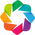

BokehModel(combine_events=True, render_bundle={'docs_json': {'39805e8d-4bc7-46ae-b62d-accef8a1d3ce': {'version…

In [90]:
v = h.visualize()